# Labeling

For each ticker, we want to label the best buy/sell/hold actions (this is the classification label we will train on).

The process goes like this:

- iterate over prices for the ticker (over time)
- e.g. prices: 
- for the first record, we will buy 1 share at that price (this becomes our balance)
- for every following record:
    - if the current price is more than the previous price
        - action = "sell"
        - if previous action is "sell", set previous row action to "hold"
    - if the current price is less than the previous price
        - action = "buy"
        - if previous action is "buy", set previous row action to "hold"
    - keep track of cost basis and profit/loss based on current liquid and realized values

This will iterate like so over the following price list:

- prices = [20, 21, 22, 18, 17, 16, 17]
- actions = 
- buy
- buy, sell
- buy, hold, sell
- buy, hold, sell, buy
- buy, hold, sell, hold, buy
- buy, hold, sell, hold, hold, buy
- buy, hold, sell, hold, hold, buy, sell (final action list)
- $3 profit

In [13]:
import pandas as pd
import os
import matplotlib.pylab as plt

In [14]:
df = pd.read_csv('signals.csv',index_col=None, header=None)
df.columns = ["ticker","price","change","time","meta_signal","meta_previous",
                "4h","1d","1w","1m",
                "4hp","1dp","1wp","1mp",
                "4h_rsi","4h_stochrsi","4h_stoch","4h_ult","4h_macd","4h_hull",
                "1d_rsi","1d_stochrsi","1d_stoch","1d_ult","1d_macd","1d_hull",
                "1w_rsi","1w_stochrsi","1w_stoch","1w_ult","1w_macd","1w_hull",
                "1m_rsi","1m_stochrsi","1m_stoch","1m_ult","1m_macd","1m_hull"
                ,"market","name","meta_move"
                ]
df.head(5)

,ticker,price,change,time,meta_signal,meta_previous,4h,1d,1w,1m,...,1w_hull,1m_rsi,1m_stochrsi,1m_stoch,1m_ult,1m_macd,1m_hull,market,name,meta_move
0,NASDAQ-AAPL,215.05,0.0000,1534986919851,1,2,1,1,1,1,...,88.93,62.55,1.0,-1,-1,-1,1.0,NASDAQ,AAPL,-1
1,NASDAQ-AAPL,215.97,0.0043,1535031826650,1,2,1,1,1,1,...,89.25,62.95,1.0,1,-1,-1,1.0,NASDAQ,AAPL,-1
2,NASDAQ-AAPL,216.11,0.0006,1535035652301,1,2,1,1,1,1,...,89.33,63.06,1.0,1,-1,-1,1.0,NASDAQ,AAPL,-1
3,NASDAQ-AAPL,215.37,-0.0034,1535039080621,1,2,1,1,1,1,...,89.01,62.66,1.0,1,-1,-1,1.0,NASDAQ,AAPL,-1
4,NASDAQ-AAPL,216.27,0.0042,1535042375489,1,2,1,1,1,1,...,89.39,63.13,1.0,1,-1,-1,1.0,NASDAQ,AAPL,-1


In [15]:
aapl = df[df.name.astype(str).str.match("AAPL")]
aapl

,ticker,price,change,time,meta_signal,meta_previous,4h,1d,1w,1m,...,1w_hull,1m_rsi,1m_stochrsi,1m_stoch,1m_ult,1m_macd,1m_hull,market,name,meta_move
0,NASDAQ-AAPL,215.050,0.0000,1534986919851,1,2,1,1,1,1,...,88.93,62.55,1.0,-1,-1,-1,1.0,NASDAQ,AAPL,-1
1,NASDAQ-AAPL,215.970,0.0043,1535031826650,1,2,1,1,1,1,...,89.25,62.95,1.0,1,-1,-1,1.0,NASDAQ,AAPL,-1
2,NASDAQ-AAPL,216.110,0.0006,1535035652301,1,2,1,1,1,1,...,89.33,63.06,1.0,1,-1,-1,1.0,NASDAQ,AAPL,-1
3,NASDAQ-AAPL,215.370,-0.0034,1535039080621,1,2,1,1,1,1,...,89.01,62.66,1.0,1,-1,-1,1.0,NASDAQ,AAPL,-1
4,NASDAQ-AAPL,216.270,0.0042,1535042375489,1,2,1,1,1,1,...,89.39,63.13,1.0,1,-1,-1,1.0,NASDAQ,AAPL,-1
5,NASDAQ-AAPL,216.050,-0.0010,1535045619331,1,2,1,1,1,1,...,89.29,63.01,1.0,1,-1,-1,1.0,NASDAQ,AAPL,-1
6,NASDAQ-AAPL,216.610,0.0026,1535048848745,1,2,1,1,1,1,...,89.54,63.32,1.0,1,-1,-1,1.0,NASDAQ,AAPL,-1
7,NASDAQ-AAPL,216.430,-0.0008,1535052085487,1,2,1,1,1,1,...,89.47,63.22,1.0,1,-1,-1,1.0,NASDAQ,AAPL,-1
8,NASDAQ-AAPL,215.490,-0.0043,1535055290889,1,2,1,1,1,1,...,89.06,62.71,1.0,1,-1,-1,1.0,NASDAQ,AAPL,-1
9,NASDAQ-AAPL,215.490,0.0000,1535058517286,1,2,1,1,1,1,...,89.06,62.71,1.0,1,-1,-1,1.0,NASDAQ,AAPL,-1


<IPython.core.display.Javascript object>


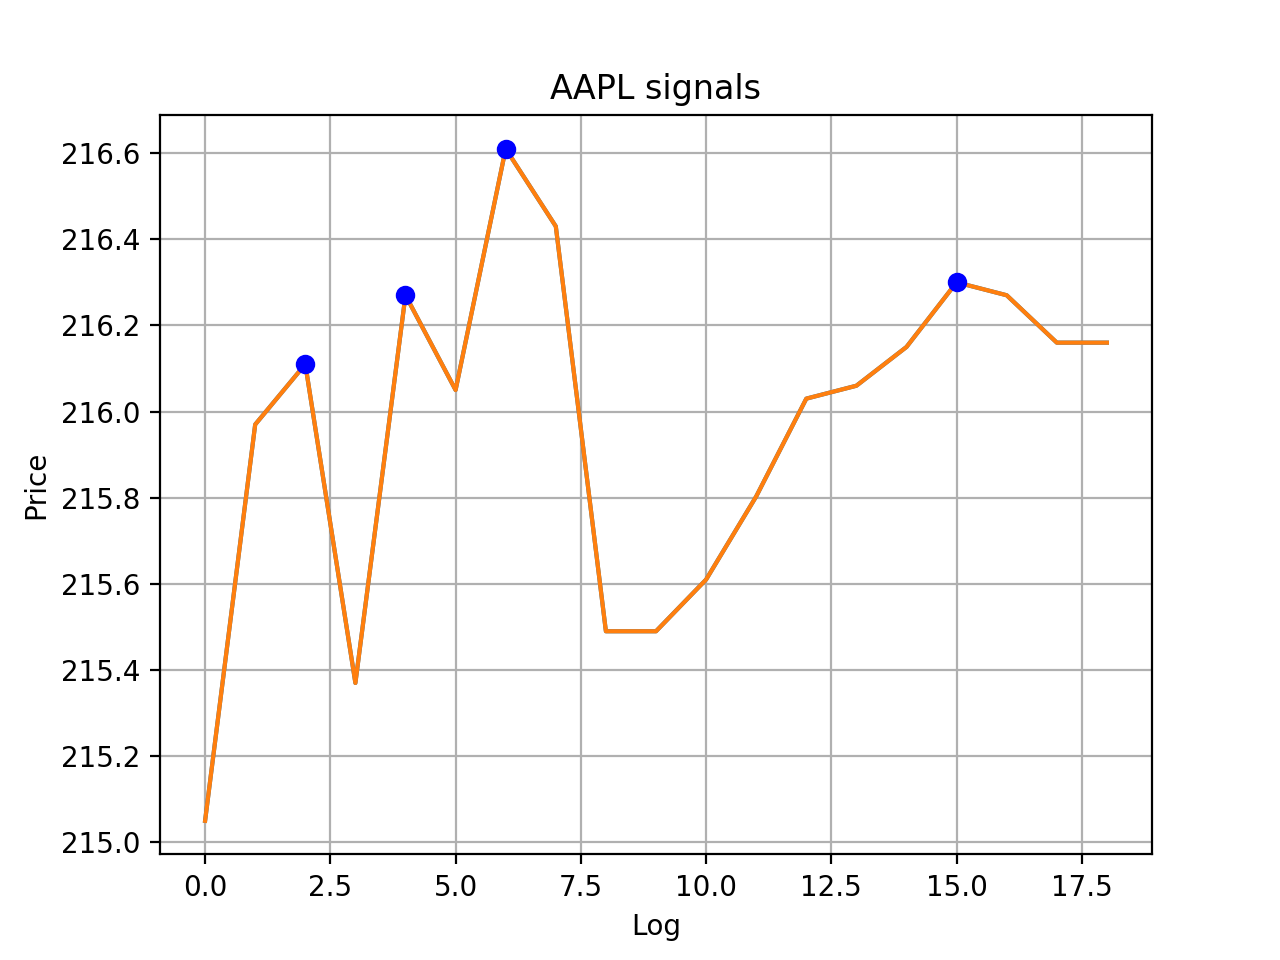

In [18]:
%matplotlib notebook

plt.title('AAPL prices')
plt.xlabel('Log')
plt.ylabel('Price')
plt.plot(aapl.price)
plt.grid(True)
plt.show()

In [35]:
aapl['action'] = 'hold'
holding=0
cost=0
profit=0
for i, row in aapl.iterrows():
  # default to hold action
  aapl.set_value(i,'action','hold')
  if i==0:
    # buy one
    holding = 1
    cost = row.price
    aapl.set_value(i,'action','buy')
  else:
    last_row = aapl.iloc[i-1]
#     print('last', i, last_row.price)
    if row.price > last_row.price:
        aapl.set_value(i,'action','sell')
        if last_row.action == "sell":
            aapl.set_value(i-1,'action','hold')
        else:
            holding-=1
            profit += row.price - cost
    elif row.price < last_row.price:
        aapl.set_value(i,'action','buy')
        if last_row.action == "buy":
            aapl.set_value(i-1,'action','hold')
        else:
            holding+=1
    
print(holding)
print(cost)
print(profit)
debug = pd.DataFrame(aapl[['price','time','action']])
debug

last 1 215.05
last 2 215.97
last 3 216.11
last 4 215.37
last 5 216.27
last 6 216.05
last 7 216.61
last 8 216.43
last 9 215.49
last 10 215.49
last 11 215.61
last 12 215.803
last 13 216.03
last 14 216.06
last 15 216.15
last 16 216.3
last 17 216.27
last 18 216.16
1
215.05
4.259999999999991


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,price,time,action
0,215.050,1534986919851,buy
1,215.970,1535031826650,hold
2,216.110,1535035652301,sell
3,215.370,1535039080621,buy
4,216.270,1535042375489,sell
5,216.050,1535045619331,buy
6,216.610,1535048848745,sell
7,216.430,1535052085487,hold
8,215.490,1535055290889,buy
9,215.490,1535058517286,hold


<IPython.core.display.Javascript object>


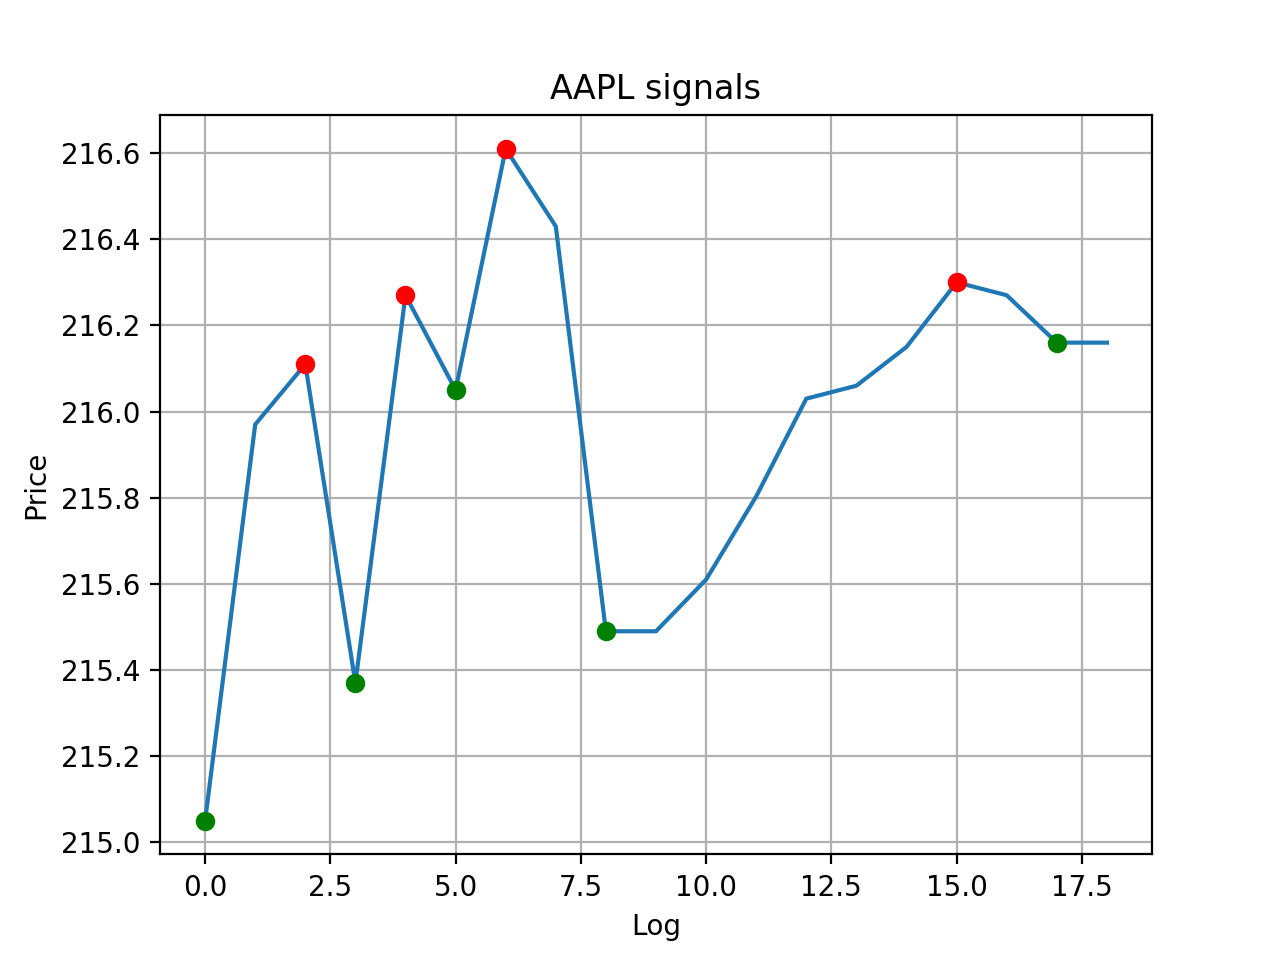

In [40]:
%matplotlib notebook
plt.title('AAPL signals')
plt.xlabel('Log')
plt.ylabel('Price')
plt.plot(aapl.price)
plt.plot(aapl[aapl.action=="sell"].price, 'ro', label='sell')
plt.plot(aapl[aapl.action=="buy"].price, 'go', label='buy')
plt.grid(True)
plt.show()